## For Technical Summary Figure
### Load Libraries
Note that I used python uncertainties package to compute uncertainties instead of manual calculation inputting formula.
You would need to do:

**pip install uncertainties**

In [1]:
# For scientific computing
import numpy as np
from scipy.stats import norm
from scipy.stats import poisson
from scipy.special import factorial
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy.stats import chi2
import scipy.integrate as integrate

# For plotting
import matplotlib.pyplot as plt

from uncertainties import ufloat
from uncertainties.umath import *  #e.g. sqrt()
from uncertainties import unumpy

In [2]:
# --------------------------------------------------------------------------------------------------
# Read Data
# --------------------------------------------------------------------------------------------------

#global string for labelling
labely = "T (s)"
labelx = "l (cm)"

#global constants
a = 100  # bar dimension 
b = 3.8  # bar dimension 
c = 0.96  # bar dimension 
g_true = 980.665 # true value of earth grav constant cm/s^2
numSmpsPerSec = 1000.0

#uncertainties 
alpha_a = 0.05 # tape measure precision
alpha_b = 0.05  # ruler precision
alpha_c = 0.005  # vernier caliber precision
alpha_l = 0.05 # ruler precision
alpha_T = np.sqrt((1/numSmpsPerSec/2)**2 + (1/numSmpsPerSec/2)**2) # photogate precision

a_ufloat = ufloat(a, alpha_a)
b_ufloat = ufloat(b, alpha_b)
k_dim_ufloat = sqrt( (a_ufloat**2 + b_ufloat**2)/12 )

T, l = np.genfromtxt(f"data/2020-12-01-photogate-data.csv", delimiter=',', 
                            unpack=True, skip_header=1, encoding='utf_8_sig')
N = len(T)

#number of parameters
n = 2

In [6]:
# --------------------------------------------------------------------------------------------------
# Fitting
# --------------------------------------------------------------------------------------------------

#inputs
x = l
y = T

alpha_x = alpha_l * np.ones(N)
alpha_y = alpha_T * np.ones(N) * 1.0185288432998927

def myFunc(x, k, g):
    return 2 * np.pi * np.sqrt((k**2 + x**2) / (g * x))

pOpt, pCov = curve_fit(myFunc, x, y,
                       p0=[28.80, 980],
                       sigma=alpha_y,
                       absolute_sigma=True
                       ) # abs sigma set to true if y error is known with the samee unit

# Assign each element of pOpt to a named variable
p0_opt = pOpt[0]
p1_opt = pOpt[1]

# Compute the standard errors for the parameters
# by taking the square root of the diagonal elements of pCov
alpha_vec = np.sqrt(np.diag(pCov))

# Assign each element of alpha_vec to a named variable
alpha_p0 = alpha_vec[0]
alpha_p1 = alpha_vec[1]

In [7]:
# ------------------------------------------------------------------------------------
# printing result 
# ------------------------------------------------------------------------------------

# Show optimized fit parameters and uncertainties
print(f"k(computed from dimension) = ({k_dim_ufloat.n:.2f} ± {k_dim_ufloat.s:.2f}) cm")
print(f"g(true) = {g_true:.1f} cm/s^2")
print(f"k = ({p0_opt:.2f} ± {alpha_p0:.2f}) cm")
print(f"g = ({p1_opt:.1f} ± {alpha_p1:.1f}) cm/s^2")

k_exp_ufloat = ufloat(p0_opt, alpha_p0)
g_ufloat = ufloat(p1_opt, alpha_p1)
T_min_true = 2 * np.pi * np.sqrt( (2 * k_dim_ufloat.n)/ g_true)
T_min_ufloat = 2 * np.pi * sqrt( (2 * k_exp_ufloat)/ g_ufloat)
print(f"Tmin(true) = {T_min_true:.2f}")
print(f"Tmin(experimental) = {T_min_ufloat:.3f}")

k(computed from dimension) = (28.89 ± 0.01) cm
g(true) = 980.7 cm/s^2
k = (28.80 ± 0.03) cm
g = (978.3 ± 1.1) cm/s^2
Tmin(true) = 1.53
Tmin(experimental) = 1.525+/-0.001


#### Now, you get to generate the figure for technical summary as following.

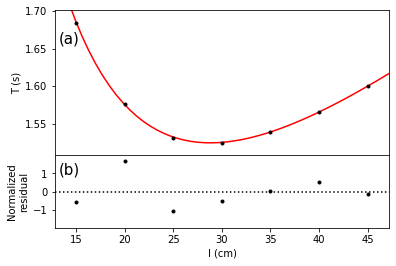

In [11]:
# plotting
# Make a grid with 2 rows, 1 colum, a 4:2 height ratio, and no 
# height space between the rows
gs = GridSpec(2, 1, height_ratios=[4, 2], hspace=0)

# Create figure
fig = plt.figure()
x_range = [np.min(x) - (np.max(x) * 1.05 - np.max(x)) , np.max(x) * 1.05]

# Compute the measurement residuals
k = p0_opt
g = p1_opt
residuals = y - myFunc(x, k, g)

# Compute the model curve
x_model = np.linspace(x_range[0], x_range[1])
y_model = myFunc(x_model, k ,g)

# Make the main plot
ax_main = fig.add_subplot(gs[0])

# Plot data as black dots
plt.errorbar(x, y, xerr=alpha_x, yerr=alpha_y, fmt='k.')

# Plot fit as a red line
plt.plot(x_model, y_model, 'r-')

# Format top panel: set axis ranges and add y-axis label
# No x-axis label here to avoid overlap with residual plot
plt.xlim(x_range[0], x_range[1])
plt.ylim(np.min(y)-(np.max(y) * 1.01 - np.max(y)), np.max(y) * 1.01)
plt.ylabel('T (s)')
#plt.title(r'$\frac{(I_+^2 + I_-^2)}{2}$ vs m plot')

# Hide x-tick labels to avoid overlap with residual plot
# plt.yticks(np.arange(floor(10 * (np.min(y)-(np.max(y) * 1.01 - np.max(y))))/10, ceil((np.max(y)) * 10)/10, 0.05))

ax_main.text(0.075, 0.75, '(a)',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax_main.transAxes,
        fontsize=15)

# Make the residual plot with a dotted zero line
# Need to adjust ylim,  yticks, ylabel for readability
ax_res = fig.add_subplot(gs[1])
ax_res.text(0.075, 0.7, '(b)',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax_res.transAxes,
        fontsize=15)

# Plot residuals as black dots
plt.plot(x, residuals/alpha_y,'k.')

# Show zero line as a black dotted line
plt.plot(x_range, [0,0], 'k:') #plt.plot([xmin,xmax],[ymin,ymax]) format

# Format bottom panel: set axis ranges, explicitly set
# y-tick values to avoid overlap with top panel, and
# add labels to x-axis and y-axis
plt.xlim(x_range[0], x_range[1])
plt.ylim(-2, 2)
plt.yticks([-1, 0, 1])
plt.xlabel(f"{labelx}")
plt.ylabel("Normalized\nresidual")
plt.savefig("plot.pdf")